### Hello, and welcome to this tutorial on simulating circuit noise in Tequila! In this tutorial, we will briefly detail how noise is commonly modelled in quantum circuits, before diving in to building NoiseModels and applying them to sampling different circuits.

# <center>1. What IS Noise, Anyway?</center>

In case you need a quick refresher: Real quantum systems undergo the effects of noise, a catch-all term for 'anything I didn't ask the computer to do'. Such noise can be caused by a number of physical processes, including but not limited to: 

 - #### Thermal fluctuations
 - #### Interaction with the environment
 - #### Uncontrolled interaction between qubits (cross-talk)
 - #### Imperfections in gate implementation
 


# <center> 2. What is noise, mathematically?</center>


Commonly, the effects of noise on quantum systems are treated as the evolution of the system's density matrix under Krauss maps. Krauss maps are mappings of the form $ A: \rho \rightarrow \rho' = \sum_{i} A_i \rho A_{i}^{\dagger}$, where $\sum_{i} A_i  A_{i}^{\dagger} = I$. These Krauss maps are parametrized, in general by probabilities.

For example, bit flip noise -- which takes qubits from the 0 to the 1 state and vice versa-- is a krauss map with two operators, and a single probabilistic parameter, p. The operators are:
#### $$A_0 = \sqrt{1-p} I,  A_1 = \sqrt{p} X$$
#### Note that the square root is present, so that bit flip map is:
#### $$ A_{bf}(p): \rho \rightarrow (1-p) * I\rho I + p * X\rho X$$
other noise operations may be defined similarly.

#### Note that such krauss operators may only affect subsystems of the system; one can have a single qubit undergo bit-flip noise in an 8 qubit state. In such cases, the krauss maps are merely the 1-qubit maps tensored with the identity on all other qubits. Multi-qubit krauss operators will involve tensor products of single qubit krauss operators.

For example, the 2-qubit bit flip krauss map has 4 operators:
$$A_{00}=(1-p)I\otimes I, A_{01}=\sqrt{p-p^2}I\otimes X,A_{10}=\sqrt{p-p^2}X \otimes I,A_{11}=pX\otimes X$$
Which are just all the tensor products of $A_{0}$ and $A_{1}$.

# <center> 3. How is noise simulated, then? </center>

Different simulation packages handle noise in radically different ways.

Cirq and Qulacs, for example, use noise channels, parametrized operations which are inserted into circuits the same way regular, unitary gates are. 

Pyquil asks its users to define noisy gate operations, and then instantiate those. 

Qiskit, meanwhile, simply takes a dictionary-like object as an argument to its simulator, and applies the noise on the user-chosen gates.

In tequila, we try to hew toward making users write as few lines of code as possible. We therefore implement a simple framework for the application of noise, meant to be compatible with all our supported platforms. To do this, we make a few assumptions:

1. If noise is present, any gate may be affected by noise.
2. The noise that affects 1..k..n-qubit gates is independent of the noise on 1...k-1,k+1...n qubit gates.
3. The number of qubits involved in a gate, not the operation performed, dictates what noises may occur.
4. Noise probabilities are independent of position in the circuit.
5. 


#### with these assumptions in mind, we turn at last to Tequila itself!

# <center>4: Noise in Tequila!</center>
### At present, only certain noises are permitted, chosen because they are supported by all of our simulator backends. The easiest way to initialize a NoiseModel is using the convenienence functions that correspond to the 6 supported noises. 

In [1]:
### first, we import tequila!
import tequila as tq
from tequila.circuit.noise import BitFlip,PhaseFlip,AmplitudeDamp,PhaseDamp,PhaseAmplitudeDamp,DepolarizingError

running build_ext
skipping '/Users/sumneralperin-lea/.pyxbld/temp.macosx-10.9-x86_64-3.6/pyrex/BayesianNetwork/kernel_prob_reshaping.cpp' Cython extension (up-to-date)
skipping 'BayesianNetwork.kernel_prob_reshaping' extension (up-to-date)
running build_ext
skipping '/Users/sumneralperin-lea/.pyxbld/temp.macosx-10.9-x86_64-3.6/pyrex/BayesianNetwork/kernel_evaluations.cpp' Cython extension (up-to-date)
skipping 'BayesianNetwork.kernel_evaluations' extension (up-to-date)


/Users/sumneralperin-lea/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/sumneralperin-lea/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/sumneralperin-lea/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/sumneralperin-lea/.local/lib/python3.6/site-pack

**let's build a nice ExpectationValue to play with:**

In [2]:
H=tq.paulis.Qm(1) ### this hamiltonian is 1 for a qubit that is 0, and 1 for a qubit that is zero.
U=tq.gates.X(0)+tq.gates.CNOT(0,1)
O=tq.ExpectationValue(U=U,H=H)
print(U)

circuit: 
X(target=(0,))
X(target=(1,), control=(0,))



Say that we wanted a noise model where 1-qubit gates and 2-qubit gates undergo bit flips, but with different probabilities.

In [3]:
bf_1=BitFlip(p=0.1,level=1)
bf_2=BitFlip(p=0.3,level=2)

 NoiseModel objects, like those initialized above, can be combined into new NoiseModels by simple addition!

In [4]:
my_nm=bf_1+bf_2
print(my_nm)

NoiseModel with: 
bit flip on 1 qubit gates, probs = [0.1],
bit flip on 2 qubit gates, probs = [0.3],



#### Let's simulate both with and without noise, and see what happens!
**NOTE:  to use noise in a simulation, you have to SAMPLE! this is because the noise is probablistic.**

In [5]:
E=tq.simulate(O)
### noise models are fed to tequila functions with the noise keyword.
E_noisy=tq.simulate(O,samples=5000,noise=my_nm)
print('Without noise, E =',E)
print('With noise, E =',E_noisy)

Without noise, E = 1.0
With noise, E = 0.6624


#### Because noise is stochastic, if your number of samples is low, you may get different values back every time.

In [6]:
for i in range(1,11):
    print('round',i,'sampling with 5 samples, E = ', tq.simulate(O,samples=5,noise=my_nm))


round 1 sampling with 5 samples, E =  0.6
round 2 sampling with 5 samples, E =  0.8
round 3 sampling with 5 samples, E =  0.8
round 4 sampling with 5 samples, E =  1.0
round 5 sampling with 5 samples, E =  0.6
round 6 sampling with 5 samples, E =  0.2
round 7 sampling with 5 samples, E =  0.8
round 8 sampling with 5 samples, E =  0.2
round 9 sampling with 5 samples, E =  0.4
round 10 sampling with 5 samples, E =  0.4


**Note that the BitFlip functions returned NoiseModels in their own right:**


In [7]:
E_1_only=tq.simulate(O,samples=5000,noise_model=bf_1)
print('With 1-qubit noise only, E =',E_1_only)
E_2_only=tq.simulate(O,samples=5000,noise_model=bf_2)
print('With 2-qubit noise only, E =',E_2_only)

With 1-qubit noise only, E = 0.8966000000000001
With 2-qubit noise only, E = 0.7008


### We also note that the order in which you apply noise matters, as the operations applied by noise do not generally commute. Compare the following results in the example below, where Amplitude Damping is the krauss map that takes 1 to 0 but leaves 0 unaffected.


In [8]:
amp=AmplitudeDamp(0.3,1)
bit=BitFlip(0.4,1)
forward=amp+bit
backward=bit+amp

H = tq.paulis.Z(0)
U = tq.gates.X(target=0)
O = tq.ExpectationValue(U=U, H=H)

E_1 = tq.simulate(O,backend='cirq',samples=100000,noise=forward)
E_2 = tq.simulate(O,backend='cirq',samples=100000,noise=backward)
print('amplitude damping before bit flip leads to E = ',E_1)
print('amplitude damping after bit flip leads to E = ',E_2)

amplitude damping before bit flip leads to E =  -0.07934
amplitude damping after bit flip leads to E =  0.15966


**Tequila will *always* attempt to apply noise to the circuit *in the order each noise was added to the noise model*. Some backends have behavior which is harder to control than others, but in general, this order will be preserved.**

### You can also optimize noisy circuits, to test the effect of noise on your algorithms! 

In [9]:
from tequila.optimizers.optimizer_gd import minimize
import numpy as np

#### Consider the 1-qubit expectation value, $<0|U^{\dagger}\hat{Y}U|0>$, with $U=H Rz(\theta) H $. In the absence of noise, this expectation value just yields $Sin(\theta)$. This circuit therefore has a minimum at $\theta = -\pi$. We can minimize this circuit under phase flip noise -- which is probabilistic application of pauli Z -- and see what happens!

optimizing expectation value with phase flip probability 0.0031635356548872064
a : 3.141592653589793



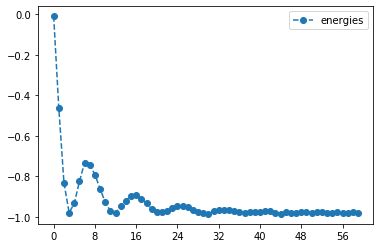

In [31]:
U=tq.gates.H(0) +tq.gates.Rz('a',0)+tq.gates.H(0)
H=tq.paulis.Y(0)
O=tq.ExpectationValue(U=U,H=H)

### we pick a random, small probability to apply noise
p=np.random.uniform(0,.1)
NM=PhaseFlip(p,1)

print('optimizing expectation value with phase flip probability {}'.format(str(p)))
result=minimize(O,lr=0.5,maxiter=60,initial_values={'a':np.pi},method='_adam',samples=5000,noise=NM,silent=True)

result.history.plot()

#### The final energy, of course, is not -1, because the application of noise leads the expected output to be $(-1+2*p)^{3} Sin(\theta)$. One sees that this is approximately the value reached by minimizing $\theta$:

In [33]:
out=result.energy
best=((-1+2*p)**3)*np.sin(np.pi/2)
print('best energy: ',out)
print('expected best ',best)

best energy:  -0.9856
expected best  -0.981138628280502


## This concludes our brief tutorial on Noise. Stay tuned (and up to date) for more exciting noise features in the future!